#**Imports**

The project is implemented using [PyTorch](https://pytorch.org/) framework.

In [21]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import time
import random
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from torchvision.transforms.functional import to_pil_image
from torchvision import models
from torchvision import transforms as T

from fastai.callbacks import hook_outputs
from fastai.torch_core import requires_grad, children

In [22]:
torch.backends.cudnn.deterministic = True 
# check if training using GPU is possible
torch.cuda.is_available()

True

#**Downloading dataset from Google Drive**

Link to the Dataset on Kaggle: [MyPaintBrushstrokes](https://www.kaggle.com/reiinakano/mypaint_brushstrokes). 

Consists of $78$ episode files, detailed description of which is given in the repository of the project: https://github.com/Olllga/DM_project.

Dataset has been loaded to the Google Drive in the first project notebook, now we just have to properly load it.

In [23]:
# mounting Google Drive with your credentials 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
# folder, created in advance in the Google Drive and containing kaggle.json
#project_folder = '/content/gdrive/MyDrive/Kaggle/NaturalPainters' # for parent email
project_folder = '/content/gdrive/MyDrive/NaturalPainters' # for alternative emails
os.environ['KAGGLE_CONFIG_DIR'] = project_folder

In [25]:
# dive into folder
#%cd /content/gdrive/MyDrive/Kaggle/NaturalPainters
%cd /content/gdrive/MyDrive/NaturalPainters

/content/gdrive/.shortcut-targets-by-id/1m2LH2VheZ1KLU1PiFqOKItm5-sBWZ1C4/NaturalPainters


This is the $3$rd notebook in the project, consisting of the $4$ notebooks. 

In the previous module the **Generator and Discriminator** models have been created to be loaded now **as pre-trained** into combined GAN architecture and **fine-tuned**.

In [26]:
# path to load the generator weights
generator_path = project_folder + '/models/generator/generator_5152w_15e_1d_best.pth'
# path to load the discriminator weights
discriminator_path = project_folder + '/models/discriminator/discriminator_10e_513seed.pth'
# path to save GAN generator and discriminator
gan_path = project_folder + '/models/gan/'
# path to save progress of generated strokes
gen_strokes_path = project_folder + '/images/gen_strokes_images/gan/GAN_generator_'
# path to save gan loss
plots_path = project_folder + '/images/loss_plots/GAN_'

In [28]:
# for repeatability of the experiments
current_best = False
if current_best:
    SEED = 4
else:
    SEED = random.randint(1, 1000)
print(f'Series of experiments corresponding to a SEED = {SEED} be recreated.')

Series of experiments corresponding to a SEED = 930 be recreated.


In [29]:
# utility for automatic generation of unique paths for saving
def generate_path(epochs):
    # to avoid overwriting while saving models
    dt = datetime.datetime.now().replace(second = 0, microsecond = 0)

    save_path = str(dt).strip() + f'_{epochs}e_{SEED}seed'

    return gen_strokes_path + save_path + '.png', gan_path + 'GAN_generator_' + save_path + '.pth', gan_path + 'GAN_discriminator_' + save_path + '.pth', plots_path + save_path + '.png'

In [30]:
# data is stored in the 'episodes_i.npz' format, where i is in {0,...,77}
# this routine loads desired 'episodes_i.npz' for a particular i
# data will be loaded in the dictionary with two fields: 'strokes' and 'actions'
def load_data(npz):

    data = np.load('strokes-dataset/' + npz)
    return data['strokes'], data['actions']

In [31]:
# function that creates from strokes and actions tensor dataset appropriate as input to dataloader
def create_dataset(current_npz):

    strokes, actions = load_data(current_npz)
    print(f'Strokes shape is {strokes.shape}.')
    print(f'Actions shape is {actions.shape}.')

    # convert to tensor type and reshape from (H x W x C) to (C x H x W)
    strokes = torch.stack([torch.from_numpy(stroke).permute(2, 0, 1) for stroke in strokes])
    # convert to tensor type and specify dtype
    actions = torch.stack([torch.from_numpy(action).float() for action in actions])
    
    return TensorDataset(strokes, actions)

# **GAN**

This notebook is devoted to the entire GAN, consisting on two model blocks, Generator and Discriminator, combined together and trained in adversarial fashison..

**Goal:** to train the best possible GAN Generator to be later used in a Nerual Painter for strokes generation.

## **Generator Model**

Defining the Generator model layers.

In [32]:
class Generator(nn.Module):

    def __init__(self, 
                 in_features: int,
                 img_height: int,
                 img_width: int,
                 num_features: int,
                 img_channels: int):
        super(Generator, self).__init__()
      
        # we want to obtain 64 x 64 images
        self.out_features = img_height * img_width

        # (12, 64 x 64) = (12, 4096), 12 - shape of each action
        self.lin = nn.Linear(in_features, self.out_features)
        # (4096, 512), 512 - downsampling hparam
        self.conv1 = nn.ConvTranspose2d(self.out_features, num_features, 
                                        kernel_size = (4, 4), stride = (1, 1), bias = False)
        self.norm1 = nn.BatchNorm2d(num_features) # 512
        # (512, 256)
        self.conv2 = nn.ConvTranspose2d(num_features, num_features//2, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
        num_features //= 2
        self.norm2 = nn.BatchNorm2d(num_features) # 256
        # (256, 128)
        self.conv3 = nn.ConvTranspose2d(num_features, num_features//2, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
        num_features //= 2
        self.norm3 = nn.BatchNorm2d(num_features) # 128
        # (128, 64)
        self.conv4 = nn.ConvTranspose2d(num_features, num_features//2, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
        num_features //= 2
        self.norm4 = nn.BatchNorm2d(num_features) # 64
        # (64, 64)
        self.conv5 = nn.ConvTranspose2d(num_features, num_features, 
                                        kernel_size = (3, 3), stride = (1, 1), padding = (1, 1), bias = False)
        self.norm5 = nn.BatchNorm2d(num_features) # 64
        # (64, 3)
        self.conv6 = nn.ConvTranspose2d(num_features, img_channels, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)



    def forward(self, x):
        # fully-convolutional layer
        x = self.lin(x)
        # CNN: all non-residual convolutional layers are followed by spatial batch normalization and ReLU nonlinearities 
        # with the exception of the output layer: uses a scaled tanh to ensure that the output image has pixels in range [0, 255]
        x = F.relu(self.conv1(x.view(x.size(0), x.size(1), 1, 1)), inplace = True)
        x = self.norm1(x)
        x = F.relu(self.conv2(x), inplace = True)
        x = self.norm2(x)
        x = F.relu(self.conv3(x), inplace = True)
        x = self.norm3(x)
        x = F.relu(self.conv4(x), inplace = True)
        x = self.norm4(x)
        x = F.relu(self.conv5(x), inplace = True)
        x = self.norm5(x)

        return torch.tanh(self.conv6(x))

In [33]:
# to check created model
generator = Generator(12, 64, 64, 512, 3)
generator

Generator(
  (lin): Linear(in_features=12, out_features=4096, bias=True)
  (conv1): ConvTranspose2d(4096, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

## **Feature Extractor**

To train the GAN Generator, half of the loss is the **Pereptual Loss:** https://arxiv.org/abs/1603.08155.

To compute it we need to load **pre-trained Feature Extractor**. Choice of the Extractor $-$ one of the hyperparameters of the pipeline.

19-layers VGG (**VGG-19**) with batch normalization pre-trained on ImageNet: https://arxiv.org/pdf/1409.1556.pdf has been chosen.

In [34]:
class FeatureExtractor(nn.Module):

    def __init__(self, 
                 layers_weights,
                 lambda_s,
                 device):
      super(FeatureExtractor, self).__init__()
      
      self.layers_weights = layers_weights # hparam
      self.lambda_s = lambda_s # weighting factor for style reconstruction loss
      self.device = device
      self.feature_extractor, self.layers_indices = self.extractor() # load Feature Extractor 

      # return Hooks that store activations of all modules in self.stored
      # function that creates a Hook for all passed modules that simply stores the output of the layers 
      # we take only modules of interest
      self.outputs = hook_outputs([self.feature_extractor[i] for i in self.layers_indices], detach = False)

    def extractor(self):

        print('\nDownload VGG19 (batch normalized) as pre-trained.\n')
        # evaluation regime, no need to re-train
        extractor = models.vgg19_bn(pretrained = True, progress = True).features.eval()

        if self.device == 'cuda':
            extractor = extractor.cuda()

        # don't want to compute gradients
        requires_grad(extractor, False)

        # features and list of indices of layers with activations (only last ones for high-level features)
        return extractor, [i - 1 for i, layer in enumerate(children(extractor)) if isinstance(layer, nn.MaxPool2d)][2:]

    # Gram matrix G is used to compute Style Reconstruction Loss
    # C x H x W - image size
    # features - C-dimensional features for each cell on H x W image grid
    # G is proportional to the uncentered covariance of the C-dimensional features, treating each grif location independently
    # idea - captures information about which features tend to activate together
    def gram_matrix(self, input):

        (batch_size, c, h, w) = input.size()
        # Gram matrix can be computed efficiently by reshaping into (c, hw)
        features = input.view(batch_size, c, h * w)
        G = features @ features.transpose(1, 2)
        # C x H x W is a normalizing factor
        return G.div(c * h * w)

    # where the perceptual loss is computed
    def forward(self, gen_stroke, true_stroke):

        # put extracted features of the generated image into storage
        self.feature_extractor(gen_stroke)
        # create list of features of each layer taking them from storage
        gen_stroke_features = [out for out in self.outputs.stored]
        
        # repeat procedure for the true image
        self.feature_extractor(true_stroke)
        true_stroke_features = [out.clone() for out in self.outputs.stored]

        # weighted sum of Feature Reconstruction Loss, Style Reconstruction Loss and 
        self.loss = []
        
        # Feature Reconstruction Loss
        # penalizes deviations in content and overall spacial structure
        # computed as MAE between feature maps with weight of objective lambda_c
        # lambda_c is a list of weights - different for each level of feature maps, it is stored in self.layers_weights
        feature_loss = [F.l1_loss(gen_layer, true_layer) * weight 
                        for gen_layer, true_layer, weight in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]
        
        # Style Reconstruction Loss
        # penalizes differences in style: colors, textures, exact shapes, common patterns, etc
        # computed as MAE between gram matriceswith weight of objective lambda_s
        # lambda_s is a list of weights - different for each level of freature maps
        # but in our case lambda_s is a constant factor intended to tweak importance between Feature and Style Reconstruction Losses
        # style_loss_weight[i] = feature_loss_weight[i]^2 * lambda_s
        style_loss = [F.l1_loss(self.gram_matrix(gen_layer), self.gram_matrix(true_layer)) * weight**2 * self.lambda_s 
                      for gen_layer, true_layer, weight  in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]

        # Pixel Loss
        # encourages the pixels of the generated image to exactly match the pixels of the target image
        # computed as MAE between two images
        pixel_loss = [F.l1_loss(gen_stroke, true_stroke)]

        self.loss += feature_loss + style_loss + pixel_loss
                
        return sum(self.loss)

    def __del__(self):
        self.outputs.remove()

## **Discriminator Model**

Defining the Discriminator model layers.

In [35]:
class Discriminator(nn.Module):
  def __init__(self, 
               img_channels: int, 
               num_features: int,
               p: float):
    super(Discriminator, self).__init__()

    # (3, 64), in this case num_features is an image size
    self.conv1 = nn.Conv2d(img_channels, num_features, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    self.dropout1 = nn.Dropout(p, inplace = False) # 0.15
    # (64, 128) - upsampling
    self.conv2 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    self.dropout2 = nn.Dropout(p*2, inplace = False) # 0.3
    num_features *= 2
    self.norm2 = nn.BatchNorm2d(num_features) # 128
    # (128, 256)
    self.conv3 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    num_features *= 2
    self.norm3 = nn.BatchNorm2d(num_features) # 256
    # (256, 512)
    self.conv4 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    num_features *= 2
    self.norm4 = nn.BatchNorm2d(num_features) # 512
    # (512, 1024)
    self.conv5 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    self.norm5 = nn.BatchNorm2d(num_features*2) # 1024
    # (1024, 1) - output is binary
    self.conv6 = nn.Conv2d(num_features*2, 1, kernel_size = (2, 2), stride = (1, 1), bias = False)


  def forward(self, x):
    # CNN: 4 upsampling convolutional layers are followed by spatial batch normalization and Leaky ReLU nonlinearities
    # Leaky ReLU is used instead of ReLU in order to decrease the growth of the Discriminator wrt Generator in GAN
    # output layer uses a sigmoid to ensure that the output is in range [0, 1]
    x = F.leaky_relu(self.conv1(x), negative_slope = 0.2, inplace = True)
    x = self.dropout1(x)
    x = F.leaky_relu(self.norm2(self.conv2(x)), negative_slope = 0.2, inplace = True)
    x = self.dropout2(x)
    x = F.leaky_relu(self.norm3(self.conv3(x)), negative_slope = 0.2, inplace = True)
    x = self.dropout2(x)
    x = F.leaky_relu(self.norm4(self.conv4(x)), negative_slope = 0.2, inplace = True)
    x = self.dropout2(x)
    x = F.leaky_relu(self.norm5(self.conv5(x)), negative_slope = 0.2, inplace = True)
    x = self.conv6(x)
    # to linearize output
    x = x.flatten(start_dim = 1)

    return torch.sigmoid(x)

In [36]:
# to check created model
discriminator = Discriminator(3, 64, 0.15)
discriminator

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dropout1): Dropout(p=0.15, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dropout2): Dropout(p=0.3, inplace=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (norm5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(1024, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
)

#**Training**

## **Trainer Class**

In [37]:
class Trainer():

        def __init__(self,
                    transforms,
                    generator: nn.Module,
                    feature_extractor: nn.Module,
                    discriminator: nn.Module,
                    g_optimizer: torch.optim,
                    d_optimizer: torch.optim,
                    loss: torch.nn.functional,
                    epochs: int = 5,
                    gpu: bool = False):
            super(Trainer, self).__init__()

            self.transforms = transforms # for strokes: casts type to float to perform rescaling and then rescales from [0, 255] to [0, 1]
            self.generator = generator # get Generator model to generate fake input
            self.feature_extractor = feature_extractor # get feature extractor to compute perceptual loss
            self.discriminator = discriminator # get Discriminator model to differentiate between fake and true
            self.g_optimizer = g_optimizer # get optimizer to perform training of the Generator
            self.d_optimizer = d_optimizer # get optimizer to perform training of the Discriminator
            self.loss = loss # get loss function to compute BCE loss
            self.epochs = epochs
            self.gpu = gpu

        def train(self,
                dataloader,
                print_interval: int = 50,
                save_img_path: str = '',
                d_save_model_path: str = '',
                g_save_model_path: str = '',
                verbose: bool = True):

            # empty canvas base to collect images of generated over training strokes
            train_gen_strokes = torch.ones_like(dataloader.sampler.data_source.tensors[0][0], dtype = torch.float32)
            d_train_loss = [] # to collect Discriminator losses from all the training steps
            g_train_loss = [] # to collect Generator losses from all the training steps
            mean_d_train_loss = [] # to collect Discriminator losses averaged over time interval starting from the beginning up to current step
            mean_g_train_loss = [] # to collect Generatoe losses averaged over time interval starting from the beginning up to current step

            print('-'*100)
            print('START OF TRAINING\n')
            for epoch in range(self.epochs):
                # regime upgrading gradients
                self.generator.train()
                self.discriminator.train()

                # empty canvas base to collect images of generated over epoch strokes
                epoch_gen_strokes = torch.ones_like(dataloader.sampler.data_source.tensors[0][0], dtype = torch.float32)

                # to compute execution time per epoch
                epoch_start_time = time.time()

                # procedures inside are performed batch-by-batch
                for i, (stroke, action) in enumerate(dataloader):  

                    # image rescaling
                    stroke = torch.stack([self.transforms(s) for s in stroke])
                    
                    # generate batch of labels
                    y_true = torch.ones((stroke.shape[0], 1), dtype = torch.float, requires_grad = False)   
                    y_gen = torch.zeros((stroke.shape[0], 1), dtype = torch.float, requires_grad = False)

                    if self.gpu:
                        action = action.cuda()
                        stroke = stroke.cuda()
                        y_true = y_true.cuda()
                        y_gen = y_gen.cuda()

                    # TRAIN DISCRIMINATOR

                    # set the gradients of optimized tensor to zero
                    self.d_optimizer.zero_grad()

                    # get prediction on batch of true strokes
                    y_true_pred = self.discriminator(stroke)

                    # generate batch of images and make a prediction on them
                    gen_stroke = self.generator(action)
                    d_y_gen_pred = self.discriminator(gen_stroke)

                    # compute Discriminator loss as BCE loss between generated and true strokes
                    # generated images are labelled as 0 (fake) and true images as 1 (true)
                    d_cur_loss = 0.5 * self.loss(y_true_pred, y_true) + 0.5 * self.loss(d_y_gen_pred, y_gen)
                    # compute the gradients
                    d_cur_loss.backward()
                    # update the values
                    self.d_optimizer.step()

                    # collect all the announced Discriminator losses, needed to collect loss history and modulate training process
                    d_train_loss.append(d_cur_loss.data.item())
                    mean_d_train_loss.append(torch.mean(torch.FloatTensor(d_train_loss)))

                    # TRAIN GENERATOR

                    # set the gradients of optimized tensor to zero
                    self.g_optimizer.zero_grad()

                    # generate batch of images and make a prediction on them
                    gen_stroke = self.generator(action)
                    g_y_gen_pred = self.discriminator(gen_stroke)

                    # compute Generator loss as average between BCE and Perceptual loss for generated strokes
                    # generated images are labelled as 1 (true)
                    g_cur_loss = 0.5 * self.loss(g_y_gen_pred, y_true) + 0.5 * self.feature_extractor(gen_stroke, stroke)
                    # compute the gradients
                    g_cur_loss.backward()
                    # update the values
                    self.g_optimizer.step()

                    # collect all the announced Generator losses, needed to collect loss history and modulate training process
                    g_train_loss.append(g_cur_loss.data.item())
                    mean_g_train_loss.append(torch.mean(torch.FloatTensor(g_train_loss)))

                    # print_interval defines a desired step to perform printing of intermediate results during training 
                    if ((i % print_interval) == 0) and verbose:
                        # current step
                        print('Epoch {}/{} | Sample {}/{}'.format((epoch + 1), self.epochs,
                                                                  (i + 1), len(dataloader)))
                        # current mean losses
                        print(' => Mean Loss of training at current step: (discriminator): {:.3f}'.format(torch.mean(torch.FloatTensor(d_train_loss))))
                        print(' => Mean Loss of training at current step: (generator): {:.3f}\n'.format(torch.mean(torch.FloatTensor(g_train_loss))))
                        
                        # to see the generated on this step stroke in comparison with what is desired
                        print('true vs generated stroke:')
                        self.display_img(torch.cat((stroke[0].clone().cpu(), gen_stroke[0].clone().cpu()), dim = 2))

                        # print out the comparative table of true labels and model predictions 
                        print('='*40)
                        print('true\t\tdiscriminator prediction')
                        print('-'*40)
                        print(f'{1}\t\t{round(y_true_pred[0].item(), 4)}')
                        print(f'{0}\t\t{round(g_y_gen_pred[0].item(), 4)}')
                        print('='*40)

                        print('-'*55)

                        # update of collection of images, generated during epoch, with image, generated at the current step
                        epoch_gen_strokes = torch.cat((epoch_gen_strokes.clone().cpu(), gen_stroke[0].clone().cpu()), dim = 2)
                        # in the beginning we just update empty collection with images of true stroke for each step
                        if epoch == 0:
                            train_gen_strokes = torch.cat((train_gen_strokes.clone().cpu(), stroke[0].clone().cpu()), dim = 2)

                # results of epoch
                print('-'*100)
                # compute time of the end of epoch
                epoch_time = time.time()- epoch_start_time
                print('End of epoch {}/{} - time: {:.3f}'.format((epoch + 1), self.epochs, epoch_time))
                print(' => Mean Loss of training at current step: (discriminator): {:.3f}'.format(torch.mean(torch.FloatTensor(d_train_loss))))
                print(' => Mean Loss of training at current step: (generator): {:.3f}\n'.format(torch.mean(torch.FloatTensor(g_train_loss))))
                print('examples of generated during epoch strokes:')
                self.display_img(epoch_gen_strokes)
                print('-'*100)

                # update of collection of images, generated during training, with collection of images, generated during epoch
                train_gen_strokes = torch.cat((train_gen_strokes, epoch_gen_strokes), dim = 1)        

            # results of training
            print('\nEND OF TRAINING')
            # saving weights of both GAN Generator (to be loaded to painter) and GAN Discriminator
            if g_save_model_path != '':
                torch.save(self.generator.state_dict(), g_save_model_path)
                print(f'GAN Generator model is saved to {g_save_model_path}.')
            if d_save_model_path != '':   
                torch.save(self.discriminator.state_dict(), d_save_model_path)
                print(f'GAN Discriminator model is saved to {d_save_model_path}.\n')
                
            print('training progress for the examples of generated strokes:')
            self.display_img(train_gen_strokes)

            if save_img_path != '':
                self.save_img(train_gen_strokes, save_img_path)

            # history of losses to be retrieved for loss plots
            return {
                'd_train_loss': d_train_loss,
                'g_train_loss': g_train_loss,
                'mean_d_train_loss': mean_d_train_loss,
                'mean_g_train_loss': mean_g_train_loss}

        # method that converts image to PIL and saves with the best possible quality
        def save_img(self, img, save_path, print_info = True):
            to_pil_image(img).save(save_path, optimize = True, subsampling = 0, quality = 100)
            if print_info:
                print(f"\nImage is saved to {save_path}.")
        # method that converts image to PIL and displays
        def display_img(self, img):
            display(to_pil_image(img))           

## **Training Playground**

Training is performed using GPU.

Strokes shape is (100000, 64, 64, 3).
Actions shape is (100000, 12).

Download VGG19 (batch normalized) as pre-trained.

----------------------------------------------------------------------------------------------------
START OF TRAINING

Epoch 1/4 | Sample 1/391
 => Mean Loss of training at current step: (discriminator): 0.003
 => Mean Loss of training at current step: (generator): 3.908

true vs generated stroke:


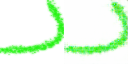

true		discriminator prediction
----------------------------------------
1		0.9896
0		0.0006
-------------------------------------------------------
Epoch 1/4 | Sample 51/391
 => Mean Loss of training at current step: (discriminator): 1.285
 => Mean Loss of training at current step: (generator): 1.130

true vs generated stroke:


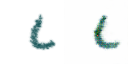

true		discriminator prediction
----------------------------------------
1		0.783
0		0.8744
-------------------------------------------------------
Epoch 1/4 | Sample 101/391
 => Mean Loss of training at current step: (discriminator): 2.072
 => Mean Loss of training at current step: (generator): 0.927

true vs generated stroke:


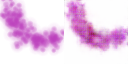

true		discriminator prediction
----------------------------------------
1		0.0814
0		0.9709
-------------------------------------------------------
Epoch 1/4 | Sample 151/391
 => Mean Loss of training at current step: (discriminator): 2.413
 => Mean Loss of training at current step: (generator): 0.850

true vs generated stroke:


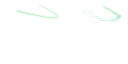

true		discriminator prediction
----------------------------------------
1		0.1806
0		0.993
-------------------------------------------------------
Epoch 1/4 | Sample 201/391
 => Mean Loss of training at current step: (discriminator): 2.520
 => Mean Loss of training at current step: (generator): 0.811

true vs generated stroke:


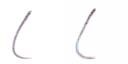

true		discriminator prediction
----------------------------------------
1		0.3158
0		0.9973
-------------------------------------------------------
Epoch 1/4 | Sample 251/391
 => Mean Loss of training at current step: (discriminator): 2.561
 => Mean Loss of training at current step: (generator): 0.790

true vs generated stroke:


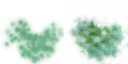

true		discriminator prediction
----------------------------------------
1		0.0847
0		0.6105
-------------------------------------------------------
Epoch 1/4 | Sample 301/391
 => Mean Loss of training at current step: (discriminator): 2.564
 => Mean Loss of training at current step: (generator): 0.778

true vs generated stroke:


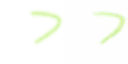

true		discriminator prediction
----------------------------------------
1		0.5232
0		0.9892
-------------------------------------------------------
Epoch 1/4 | Sample 351/391
 => Mean Loss of training at current step: (discriminator): 2.542
 => Mean Loss of training at current step: (generator): 0.772

true vs generated stroke:


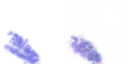

true		discriminator prediction
----------------------------------------
1		0.5688
0		0.9916
-------------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 1/4 - time: 1802.127
 => Mean Loss of training at current step: (discriminator): 2.506
 => Mean Loss of training at current step: (generator): 0.769

examples of generated during epoch strokes:


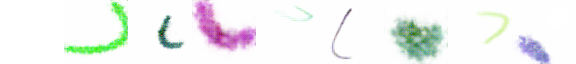

----------------------------------------------------------------------------------------------------
Epoch 2/4 | Sample 1/391
 => Mean Loss of training at current step: (discriminator): 2.505
 => Mean Loss of training at current step: (generator): 0.769

true vs generated stroke:


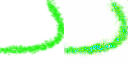

true		discriminator prediction
----------------------------------------
1		0.555
0		0.9871
-------------------------------------------------------
Epoch 2/4 | Sample 51/391
 => Mean Loss of training at current step: (discriminator): 2.450
 => Mean Loss of training at current step: (generator): 0.769

true vs generated stroke:


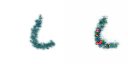

true		discriminator prediction
----------------------------------------
1		0.9857
0		0.9771
-------------------------------------------------------
Epoch 2/4 | Sample 101/391
 => Mean Loss of training at current step: (discriminator): 2.386
 => Mean Loss of training at current step: (generator): 0.772

true vs generated stroke:


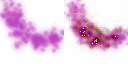

true		discriminator prediction
----------------------------------------
1		0.0473
0		0.8102
-------------------------------------------------------
Epoch 2/4 | Sample 151/391
 => Mean Loss of training at current step: (discriminator): 2.319
 => Mean Loss of training at current step: (generator): 0.777

true vs generated stroke:


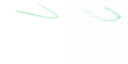

true		discriminator prediction
----------------------------------------
1		0.2348
0		0.7835
-------------------------------------------------------
Epoch 2/4 | Sample 201/391
 => Mean Loss of training at current step: (discriminator): 2.252
 => Mean Loss of training at current step: (generator): 0.783

true vs generated stroke:


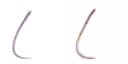

true		discriminator prediction
----------------------------------------
1		0.2626
0		0.7979
-------------------------------------------------------
Epoch 2/4 | Sample 251/391
 => Mean Loss of training at current step: (discriminator): 2.186
 => Mean Loss of training at current step: (generator): 0.791

true vs generated stroke:


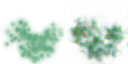

true		discriminator prediction
----------------------------------------
1		0.1361
0		0.6752
-------------------------------------------------------
Epoch 2/4 | Sample 301/391
 => Mean Loss of training at current step: (discriminator): 2.121
 => Mean Loss of training at current step: (generator): 0.800

true vs generated stroke:


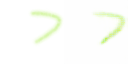

true		discriminator prediction
----------------------------------------
1		0.3535
0		0.6679
-------------------------------------------------------
Epoch 2/4 | Sample 351/391
 => Mean Loss of training at current step: (discriminator): 2.056
 => Mean Loss of training at current step: (generator): 0.810

true vs generated stroke:


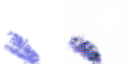

true		discriminator prediction
----------------------------------------
1		0.428
0		0.7713
-------------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 2/4 - time: 1802.234
 => Mean Loss of training at current step: (discriminator): 2.005
 => Mean Loss of training at current step: (generator): 0.818

examples of generated during epoch strokes:


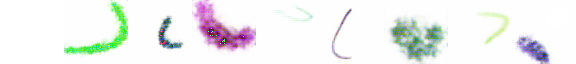

----------------------------------------------------------------------------------------------------
Epoch 3/4 | Sample 1/391
 => Mean Loss of training at current step: (discriminator): 2.004
 => Mean Loss of training at current step: (generator): 0.818

true vs generated stroke:


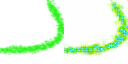

true		discriminator prediction
----------------------------------------
1		0.1593
0		0.5747
-------------------------------------------------------
Epoch 3/4 | Sample 51/391
 => Mean Loss of training at current step: (discriminator): 1.943
 => Mean Loss of training at current step: (generator): 0.829

true vs generated stroke:


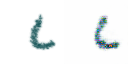

true		discriminator prediction
----------------------------------------
1		0.5438
0		0.4363
-------------------------------------------------------
Epoch 3/4 | Sample 101/391
 => Mean Loss of training at current step: (discriminator): 1.886
 => Mean Loss of training at current step: (generator): 0.838

true vs generated stroke:


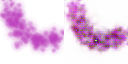

true		discriminator prediction
----------------------------------------
1		0.6511
0		0.6556
-------------------------------------------------------
Epoch 3/4 | Sample 151/391
 => Mean Loss of training at current step: (discriminator): 1.832
 => Mean Loss of training at current step: (generator): 0.847

true vs generated stroke:


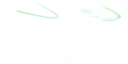

true		discriminator prediction
----------------------------------------
1		0.4064
0		0.5606
-------------------------------------------------------
Epoch 3/4 | Sample 201/391
 => Mean Loss of training at current step: (discriminator): 1.782
 => Mean Loss of training at current step: (generator): 0.855

true vs generated stroke:


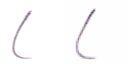

true		discriminator prediction
----------------------------------------
1		0.4381
0		0.5578
-------------------------------------------------------
Epoch 3/4 | Sample 251/391
 => Mean Loss of training at current step: (discriminator): 1.736
 => Mean Loss of training at current step: (generator): 0.862

true vs generated stroke:


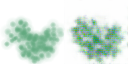

true		discriminator prediction
----------------------------------------
1		0.1142
0		0.7567
-------------------------------------------------------
Epoch 3/4 | Sample 301/391
 => Mean Loss of training at current step: (discriminator): 1.694
 => Mean Loss of training at current step: (generator): 0.869

true vs generated stroke:


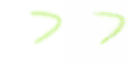

true		discriminator prediction
----------------------------------------
1		0.4714
0		0.5311
-------------------------------------------------------
Epoch 3/4 | Sample 351/391
 => Mean Loss of training at current step: (discriminator): 1.654
 => Mean Loss of training at current step: (generator): 0.875

true vs generated stroke:


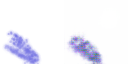

true		discriminator prediction
----------------------------------------
1		0.5564
0		0.5828
-------------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 3/4 - time: 1802.784
 => Mean Loss of training at current step: (discriminator): 1.625
 => Mean Loss of training at current step: (generator): 0.880

examples of generated during epoch strokes:


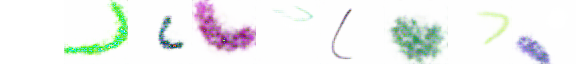

----------------------------------------------------------------------------------------------------
Epoch 4/4 | Sample 1/391
 => Mean Loss of training at current step: (discriminator): 1.624
 => Mean Loss of training at current step: (generator): 0.880

true vs generated stroke:


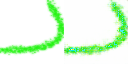

true		discriminator prediction
----------------------------------------
1		0.5826
0		0.4018
-------------------------------------------------------
Epoch 4/4 | Sample 51/391
 => Mean Loss of training at current step: (discriminator): 1.590
 => Mean Loss of training at current step: (generator): 0.885

true vs generated stroke:


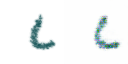

true		discriminator prediction
----------------------------------------
1		0.6007
0		0.2993
-------------------------------------------------------
Epoch 4/4 | Sample 101/391
 => Mean Loss of training at current step: (discriminator): 1.558
 => Mean Loss of training at current step: (generator): 0.890

true vs generated stroke:


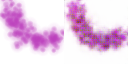

true		discriminator prediction
----------------------------------------
1		0.447
0		0.1696
-------------------------------------------------------
Epoch 4/4 | Sample 151/391
 => Mean Loss of training at current step: (discriminator): 1.528
 => Mean Loss of training at current step: (generator): 0.894

true vs generated stroke:


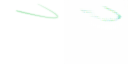

true		discriminator prediction
----------------------------------------
1		0.4568
0		0.4658
-------------------------------------------------------
Epoch 4/4 | Sample 201/391
 => Mean Loss of training at current step: (discriminator): 1.500
 => Mean Loss of training at current step: (generator): 0.898

true vs generated stroke:


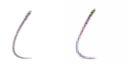

true		discriminator prediction
----------------------------------------
1		0.4403
0		0.522
-------------------------------------------------------
Epoch 4/4 | Sample 251/391
 => Mean Loss of training at current step: (discriminator): 1.474
 => Mean Loss of training at current step: (generator): 0.902

true vs generated stroke:


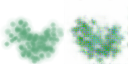

true		discriminator prediction
----------------------------------------
1		0.3809
0		0.636
-------------------------------------------------------
Epoch 4/4 | Sample 301/391
 => Mean Loss of training at current step: (discriminator): 1.450
 => Mean Loss of training at current step: (generator): 0.905

true vs generated stroke:


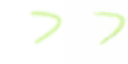

true		discriminator prediction
----------------------------------------
1		0.4575
0		0.5314
-------------------------------------------------------
Epoch 4/4 | Sample 351/391
 => Mean Loss of training at current step: (discriminator): 1.427
 => Mean Loss of training at current step: (generator): 0.908

true vs generated stroke:


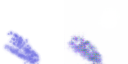

true		discriminator prediction
----------------------------------------
1		0.5565
0		0.5579
-------------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 4/4 - time: 1801.053
 => Mean Loss of training at current step: (discriminator): 1.409
 => Mean Loss of training at current step: (generator): 0.910

examples of generated during epoch strokes:


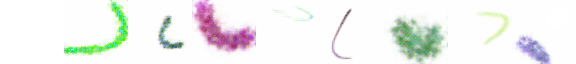

----------------------------------------------------------------------------------------------------

END OF TRAINING
GAN Generator model is saved to /content/gdrive/MyDrive/NaturalPainters/models/gan/GAN_generator_2022-02-16 23:45:00_4e_930seed.pth.
GAN Discriminator model is saved to /content/gdrive/MyDrive/NaturalPainters/models/gan/GAN_discriminator_2022-02-16 23:45:00_4e_930seed.pth.

training progress for the examples of generated strokes:


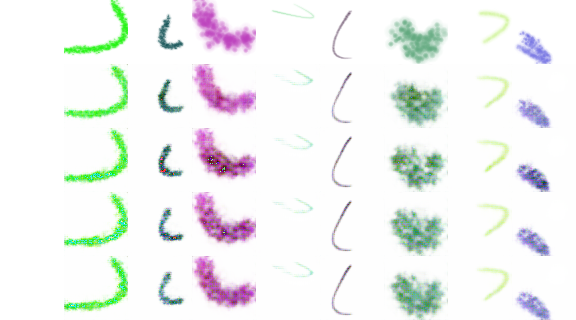


Image is saved to /content/gdrive/MyDrive/NaturalPainters/images/gen_strokes_images/gan/GAN_generator_2022-02-16 23:45:00_4e_930seed.png.


In [40]:
# set either repeated or random experiment
torch.manual_seed(SEED)

# set hyperparameters: right pannel provides the playground
class Hparams():
    in_features = 12 #constant
    num_features = 512 #@param {type:"slider", min:8, max:1024, step:8}
    img_height = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_width = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_channels = 3 #@param {type:"slider", min:1, max:3, step:2}
    p = 0.15 #@param {type:"slider", min: 0.0, max:1.0, step:0.025}
    layers_weights = [5, 15, 2] #@param
    lambda_s = 5000 #@param {type: "slider", min:1, max:5000}
    batch_size = 256 #@param {type: "slider", min:8, max:512, step:8}
    g_lr = 1e-4 #@param {type:"number"}
    d_lr = 2e-6 #@param {type:"number"}
    g_betas = (0.5, 0.9) #@param
    d_betas = (0.3, 0.7) #@param
    d_weight_decay = 1e-1 #@param {type:"slider", min:0.001, max:1.0, step:0.005}
    epochs = 4 #@param {type:"slider", min:1, max:1000, step:1}
    print_interval = 25 #@param {type:"slider", min:1, max:100, step:10}
hparams = Hparams()

# define device for training
gpu = torch.cuda.is_available()
if gpu:
    print("Training is performed using GPU.\n")
    device = 'cuda'
else:
    print("Training is performed using CPU.\n")
    device = 'cpu'

# get the dataset
current_npz = 'episodes_2.npz'
dataset = create_dataset(current_npz)

# create the loader to train by batches
dataloader = DataLoader(dataset, 
                        batch_size = hparams.batch_size, 
                        shuffle = False)

# create model instance of Generator
generator = Generator(hparams.in_features,
                      hparams.img_height,
                      hparams.img_width,
                      hparams.num_features,
                      hparams.img_channels)

# create model instance of Discriminator
discriminator = Discriminator(hparams.img_channels, 
                              hparams.img_height,
                              hparams.p)
# create model instance of Feature Extractor
feature_extractor = FeatureExtractor(hparams.layers_weights,
                                     hparams.lambda_s, 
                                     device)

# load the Generator's learnt parameters
generator.load_state_dict(torch.load(generator_path, 
                                     map_location = torch.device(device)))
# load the Discriminator's learnt parameters
discriminator.load_state_dict(torch.load(discriminator_path, 
                                     map_location = torch.device(device)))

generator.to(device)
discriminator.to(device)

# create an instance of optimizer for Generator
g_optimizer = optim.Adam(generator.parameters(), 
                       lr = hparams.g_lr, 
                       betas = hparams.g_betas)
# create an instance of optimizer for Discriminator
d_optimizer = optim.Adam(discriminator.parameters(), 
                       lr = hparams.d_lr, 
                       betas = hparams.d_betas,
                       weight_decay = hparams.d_weight_decay)

# define loss function that measures the Binary Cross Entropy
loss = F.binary_cross_entropy

# transformations on strokes
strokes_tfms = T.Compose([T.Lambda(lambda x: x.float()),
                          T.Lambda(lambda x: x.div_(255))])

# create model instance of Trainer
trainer = Trainer(strokes_tfms,
                  generator,
                  feature_extractor,
                  discriminator,
                  g_optimizer,
                  d_optimizer,
                  loss,
                  epochs = hparams.epochs,
                  gpu = gpu)

# generate paths for saving
img_path, gen_path, disc_path, loss_path = generate_path(hparams.epochs)
# call the training method with the desired saving paths
train_history = trainer.train(dataloader, 
                              print_interval = hparams.print_interval,
                              save_img_path = img_path,
                              d_save_model_path = disc_path,
                              g_save_model_path = gen_path)

## **Loss History**

In [41]:
# plot and save train loss
def plot_loss(save_loss_path = '', model_name = 'Model',
              xlim = [], ylim = [], g_color = 'darkcyan', d_color = 'maroon', alpha = 0.5,
              epochs = 15):

    fig, axs = plt.subplots()

    plt.plot(train_history['d_train_loss'], '-', color = d_color, alpha = alpha)
    plt.plot(train_history['g_train_loss'], '-', color = g_color, alpha = alpha)
    plt.plot(train_history['mean_d_train_loss'], '--', color = d_color)
    plt.plot(train_history['mean_g_train_loss'], '--', color = g_color)

    plt.title(f'{model_name} loss collected over {epochs} epochs')
    plt.ylabel('Loss')
    plt.xlabel('Step (dataset size / batch size * num epochs)')

    if xlim != []:
        plt.xlim(xlim)
    if ylim != []:
        plt.ylim(ylim)

    plt.legend(['discriminator train loss', 'generator train loss', 'mean discriminator train loss', 'mean discriminator train loss'],
               loc = 'upper right')

    if save_loss_path != '':
        fig.savefig(save_loss_path, bbox_inches = 'tight')

    plt.show()

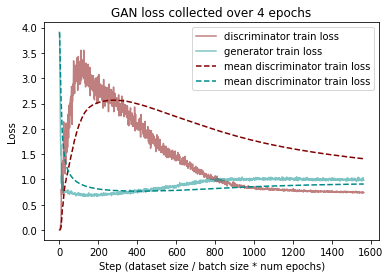

In [42]:
plot_loss(loss_path, 'GAN',
          epochs = hparams.epochs)